# Table of Contents
1. [Data Loading](#section3)
2. [Multivariate Forecasting with LSTM](#section4)
3. [Conclusion](#section5)
4. [References](#section6)

In [ ]:
pip install fredpy

In [ ]:
from numpy import array
import pandas as pd
import numpy as np
from datetime import datetime
from numpy import asarray
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
import random
from sklearn.utils import shuffle
import tensorflow as tf
import pickle
import csv
import fredpy as fp
from flask import Flask, request, jsonify, render_template
from dateutil.relativedelta import relativedelta
from datetime import date

random.seed(123)

export_path = "/content/"

# 1. Data Loading


In [ ]:
# Load FRED API key
#fp.api_key = fp.load_api_key('fred_api_key.txt')
fp.api_key = 'b4d6af7b7bad0a8d676f184880ab6b3a'

From the previous data we selected the following macro index: GDP (total economic output), CPI (inflation measure), unemployment rate, and M2 (money supply). A new data series, **WTI (West Texas Intermediate)**, which is a grade of crude oil used as a benchmark in oil pricing, has been added to the analysis

In [ ]:
gdp = fp.series('GDP')
cpi = fp.series('CPIAUCSL')
unemployment = fp.series('UNRATE')
m2 = fp.series('M2SL')
WTI = fp.series('DCOILWTICO')

In [ ]:
# Base year for NIPA deflators
cpi_base_year = cpi.units.split(' ')[1].split('=')[0]
# cpi inflation as percent change over past year
cpi = cpi.apc()
# Convert unemployment, cpi inflation, GDP data to rates
unemployment = unemployment.divide(100)
cpi = cpi.divide(100)

In [ ]:
data1 = pd.DataFrame({'WTI': WTI.data})

In [ ]:
# Create a DataFrame with actual and trend data
data = pd.DataFrame({
        'gdp':gdp.data,
        'real_m2':m2.data,
        'unemployment':unemployment.data,
        'cpi_inflation':cpi.data,
        'WTI': WTI.data
    })
data['gdp'] = data['gdp'].fillna(method='ffill')
data['WTI'] = data['WTI'].fillna(method='ffill')
data = data.dropna()

In [ ]:
data.dropna().corr()

,gdp,real_m2,unemployment,cpi_inflation,WTI
gdp,1.000000,0.970385,-0.183725,-0.010313,0.715881
real_m2,0.970385,1.000000,-0.163171,0.087150,0.625368
unemployment,-0.183725,-0.163171,1.000000,-0.336794,0.119791
cpi_inflation,-0.010313,0.087150,-0.336794,1.000000,0.094390
WTI,0.715881,0.625368,0.119791,0.094390,1.000000


In [ ]:
multivariate = data.dropna()
multivariate.to_csv(export_path+'multivariate_data.csv')

In [ ]:
multivariate_data = pd.read_csv('/content/multivariate_data.csv')


# 2. Multivariate Forecasting with LSTM

Multivariate forecasting with LSTM networks allows for the inclusion of multiple input features to predict future values.
forecasting lies in its ability to capture the relationship between multiple influencing factors and the target variable.



In [ ]:
multivariate_data['date'] = pd.to_datetime(multivariate_data['date'])
input_data = multivariate_data[['WTI','gdp', 'real_m2', 'unemployment', 'cpi_inflation']]
#input_data = multivariate_data[['gdp', 'cpi_inflation', 'unemployment']]
# scale all the input data between 0 and 1
lenght2 = input_data.shape[0]
scaler = MinMaxScaler()

In [ ]:
scaler.fit(input_data)
scaled_input_data = scaler.fit_transform(input_data)

In [ ]:
# the number of lags we will consider here (will consider other lags: p = [24,20,19,14,12])
p = 20

last2 = [ele for ele in input_data["cpi_inflation"][lenght2-p:]]
with open(export_path+"/last20data.csv", "w") as f:
    wr = csv.writer(f, delimiter="\n")
    wr.writerow(['Data'])
    wr.writerow(last2)

In [ ]:
# Omit the last 20 points for our out of sample forecast
out_of_sample_forecast_input = scaled_input_data[lenght2-p:, :]
scaled_input_data = scaled_input_data[0:lenght2-p, :]

In [ ]:
n_steps_in = 20
# we only consider as input lagged CPI for now, so n_features = 1
n_features = 5
n_steps_out = 12

In [ ]:
# let's transform our remaning data into a multivariate supervised learning problem
train_X = []
train_Y = []

for i in range(scaled_input_data.shape[0] - n_steps_in - n_steps_out):
    train_X.append(scaled_input_data[i:i + n_steps_in, :])
    train_Y.append(scaled_input_data[i + n_steps_in:i + n_steps_in + n_steps_out, 4])

train_X = asarray(train_X)
train_Y = asarray(train_Y)
train_Y = train_Y.reshape(train_Y.shape[0], train_Y.shape[1], 1)

In [ ]:
# Divide data in training and testing: keep 50 last inputs for input samples of the test data

X_test = train_X[lenght2-p-n_steps_in-n_steps_out-50:lenght2-p-n_steps_in-n_steps_out, :]
X_train = train_X[0:lenght2-p-n_steps_in-n_steps_out-50, :]
Y_test = train_Y[lenght2-p-n_steps_in-n_steps_out-50:lenght2-p-n_steps_in-n_steps_out, :]
Y_train = train_Y[0:lenght2-p-n_steps_in-n_steps_out-50, :]

In [ ]:
model = Sequential()
model.add(LSTM(75, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
# Stacked layer of LSTM's
model.add(LSTM(75, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))
model.compile(loss='mse', optimizer='adam')
training_model = model.fit(X_train, Y_train, epochs=20, verbose=1)

Epoch 1/20
12/12 [==============================] - 2s 14ms/step - loss: 0.1614
Epoch 2/20
12/12 [==============================] - 0s 22ms/step - loss: 0.0693
Epoch 3/20
12/12 [==============================] - 0s 17ms/step - loss: 0.0260
Epoch 4/20
12/12 [==============================] - 0s 14ms/step - loss: 0.0203
Epoch 5/20
12/12 [==============================] - 0s 17ms/step - loss: 0.0189
Epoch 6/20
12/12 [==============================] - 0s 15ms/step - loss: 0.0165
Epoch 7/20
12/12 [==============================] - 0s 15ms/step - loss: 0.0163
Epoch 8/20
12/12 [==============================] - 0s 14ms/step - loss: 0.0150
Epoch 9/20
12/12 [==============================] - 0s 14ms/step - loss: 0.0165
Epoch 10/20
12/12 [==============================] - 0s 14ms/step - loss: 0.0143
Epoch 11/20
12/12 [==============================] - 0s 14ms/step - loss: 0.0139
Epoch 12/20
12/12 [==============================] - 0s 13ms/step - loss: 0.0133
Epoch 13/20
12/12 [==================

Text(0.5, 1.0, 'Mean Squared Error over Training Set')

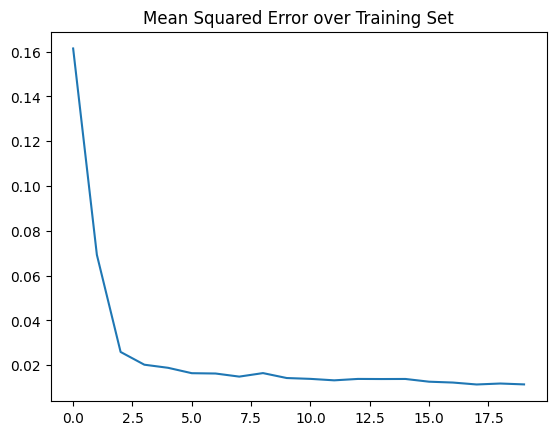

In [ ]:
plt.plot(training_model.history['loss'], label = 'Train loss')
plt.title("Mean Squared Error over Training Set")

The graph shows the model's Mean Squared Error decreasing sharply and then leveling off as training progresses, indicating initial rapid learning.


In [ ]:
scaled_out_of_sample_forecast = model.predict(out_of_sample_forecast_input.reshape(1, p, n_features))
scaled_out_of_sample_forecast = scaled_out_of_sample_forecast.reshape(n_steps_out, 1)
scaled_out_of_sample_forecast_repeated = np.repeat(scaled_out_of_sample_forecast, n_features, axis=-1)
list_forecast = scaler.inverse_transform(scaled_out_of_sample_forecast_repeated)[:, 4].tolist()

print(list_forecast)
aList = [ele for ele in list_forecast]

1/1 [==============================] - 0s 403ms/step
[0.029098400846123695, 0.02934006042778492, 0.026673929765820503, 0.030003506690263748, 0.031084932386875153, 0.029266944155097008, 0.02745632641017437, 0.02830478362739086, 0.027007518336176872, 0.027666699141263962, 0.031801436096429825, 0.03339698910713196]


In [ ]:
with open(export_path+"/model2.csv", "w") as f:
    wr = csv.writer(f, delimiter="\n")
    wr.writerow(['Data'])
    wr.writerow(aList)

In [ ]:
def plotGenerator(model, month):
    latestdata = pd.read_csv(export_path+"/last20data.csv")['Data'].tolist()
    prediction= pd.read_csv(export_path+'model{}.csv'.format(model))['Data'].tolist()[:month]
    prediction.insert(0, latestdata[-1])
    import datetime
    s = '06/2022'

    x1= [datetime.datetime.strptime(s, '%m/%Y') +relativedelta(months=i) for i in range(20)]
    x2= [datetime.datetime.strptime(s, '%m/%Y') + relativedelta(months= 19+ i) for i in range(month+ 1)]
    plt.plot(x1, latestdata, 'r', x2, prediction, 'b--')
    plt.xticks(rotation= 30)
    plt.grid()
    plt.title('Inflation prediction over {} months'.format(month))
    plt.xlabel('Date')
    plt.ylabel('Inflation Rate in %')
    plt.show()
    #plt.savefig(images+'/prediction{}.png'.format(model))
    plt.clf()

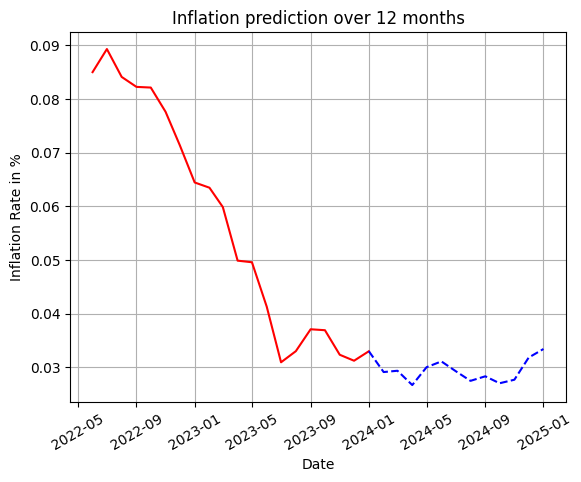

<Figure size 640x480 with 0 Axes>

In [ ]:
plotGenerator(2, 12)

# 3. Conclusion

The graph depicts a predicted decrease in inflation rates over a 12-month period, with the red line indicating the model's forecast. The trend suggests a fall in inflation to levels potentially below the 3% threshold. However, the forecast concludes with an uptick, which could imply expectations of a policy shift, such as the Federal Reserve moderating rate cuts to prevent too low an inflation rate.

But also the unexpected rise at the end raises questions about the model's predictive consistency.
